In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile as z
from PIL import Image
from imblearn.under_sampling import RandomUnderSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import os
from sklearn import preprocessing# label encoding
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = '10'

### Entire Training Dataset

In [3]:
df = pd.read_csv('all_data_info.csv')

In [4]:
print(df.shape)
df.head()

(103250, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [5]:
# number of artists
len(df['artist'].unique())

2319

In [6]:
# missing artist names?
df['artist'].isnull().sum()

0

In [7]:
# num paintings per artist
by_artist = pd.DataFrame(df['artist'].value_counts().reset_index())
by_artist.columns = ['artist','count']
by_artist

,artist,count
0,Ivan Aivazovsky,500
1,John Singer Sargent,500
2,Pierre-Auguste Renoir,500
3,Marc Chagall,500
4,Pablo Picasso,500
...,...,...
2314,Adoration of the Shepherds,1
2315,Dua,1
2316,Transfer Series,1
2317,Portrait of a Woman,1


In [8]:
# number of artists with > 200 paintings
len(by_artist[by_artist['count'] >= 200])

110

In [9]:
# remove data where < 200 paintings per artist
by_artist = by_artist[by_artist['count'] >= 200]

Text(0.5, 0, 'num paintings')

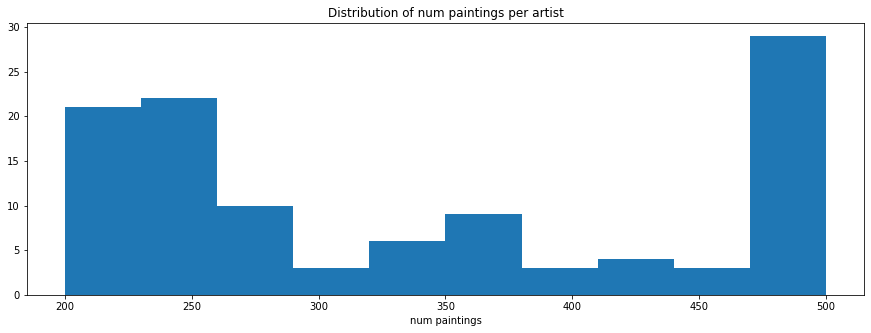

In [10]:
plt.hist(by_artist['count'])
plt.title('Distribution of num paintings per artist')
plt.xlabel('num paintings')

In [11]:
# removing artists from the main df that have < 200 paintings
df_200 = df[df['artist'].isin(by_artist['artist'])]

In [12]:
df_200.shape # 37452 rows

(37452, 12)

In [13]:
df_200['artist'].value_counts()

Ivan Aivazovsky           500
Rembrandt                 500
Zdislav Beksinski         500
Ilya Repin                500
John Singer Sargent       500
                         ... 
Honore Daumier            206
Ilya Mashkov              203
Thomas Lawrence           203
Paul Klee                 200
James McNeill Whistler    200
Name: artist, Length: 110, dtype: int64

### Subset: Train 1 and Train 2

__lines below commented so don't need to create df_sub from scratch each time - just load saved pickle file__

In [14]:
# entire training set to large so downloading subset train 1

# filenames_train1 = []
# with z.ZipFile('train_1.zip', 'r') as zip:
#     for info in zip.infolist():
#         name = info.filename.split('/')
#         filenames_train1.append(name[1])

In [15]:
# entire training set to large so downloading subset train 1

# filenames_train2 = []
# with z.ZipFile('train_2.zip', 'r') as zip:
#     for info in zip.infolist():
#         name = info.filename.split('/')
#         filenames_train2.append(name[1])

In [16]:
# train1_df = df[df['new_filename'].isin(filenames_train1)] 

In [17]:
# train2_df = df[df['new_filename'].isin(filenames_train2)] 

In [18]:
# train1_df.reset_index(inplace=True)

In [19]:
# train2_df.reset_index(inplace=True)

In [20]:
# saving train1_df and train2_df
# train1_df.to_pickle("train1_df.pkl")
# train2_df.to_pickle("train2_df.pkl")

In [21]:
# load train1 and train2 dataframes from pickle file
train1_df = pd.read_pickle("train1_df.pkl")
train2_df = pd.read_pickle("train2_df.pkl")

In [22]:
print(train1_df.shape)
train1_df.head()

(11025, 13)


,index,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,23,Jan van Eyck,1439,religious painting,4000.0,8311.0,28783029.0,wikiart,Northern Renaissance,The Madonna in the Church,train_and_test,True,16876.jpg
2,42,Thomas Gainsborough,1783,landscape,5712.0,4704.0,11791905.0,wikiart,Rococo,The Mall in St. James's Park,train_and_test,True,1164.jpg
3,46,Lyonel Feininger,1926.0,cityscape,4472.0,5894.0,7382419.0,wikiart,Cubism,Gelmeroda IX,train_only,True,19385.jpg
4,74,Henri de Toulouse-Lautrec,1895,genre painting,5833.0,3985.0,3389831.0,wikiart,Post-Impressionism,Abandonment (The pair),train_and_test,True,17354.jpg


In [23]:
print(train2_df.shape)
train2_df.head()

(8476, 13)


,index,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,5,Tosa Mitsuoki,NaN,mythological painting,25528.0,3000.0,10496349.0,wikiart,Yamato-e,Night March of a Hundred Demons (left half),train_only,True,29855.jpg
1,17,Hiroshige,NaN,bird-and-flower painting,4154.0,9051.0,5964682.0,wikiart,Ukiyo-e,Hydrangea and Kingfisher,train_and_test,True,23508.jpg
2,19,Hiroshige,1850,bird-and-flower painting,4045.0,8999.0,5930496.0,wikiart,Ukiyo-e,"Moon, Swallows and Peach Blossoms",train_and_test,True,27254.jpg
3,24,Julius LeBlanc Stewart,1896,genre painting,6980.0,4724.0,2484194.0,wikiart,Realism,Yachting in the Mediterranean,train_only,True,28908.jpg
4,30,Clara Peeters,1612.0,still life,4913.0,6007.0,8684895.0,wikiart,Baroque,Still Life with Flowers and Gold Cups of Honor,train_only,True,28363.jpg


In [24]:
# number of unique artists in train1 and train2
print("train1 num artists: ", len(train1_df['artist'].unique()))
print("train2 num artists: ", len(train2_df['artist'].unique()))

train1 num artists:  1500
train2 num artists:  1437


In [25]:
# combining both tables
df_sub = pd.concat([train1_df,train2_df], ignore_index=True)
print(df_sub.shape)
# drop 'index' col
df_sub.drop('index', axis=1, inplace=True)
df_sub.head()

(19501, 13)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Jan van Eyck,1439,religious painting,4000.0,8311.0,28783029.0,wikiart,Northern Renaissance,The Madonna in the Church,train_and_test,True,16876.jpg
2,Thomas Gainsborough,1783,landscape,5712.0,4704.0,11791905.0,wikiart,Rococo,The Mall in St. James's Park,train_and_test,True,1164.jpg
3,Lyonel Feininger,1926.0,cityscape,4472.0,5894.0,7382419.0,wikiart,Cubism,Gelmeroda IX,train_only,True,19385.jpg
4,Henri de Toulouse-Lautrec,1895,genre painting,5833.0,3985.0,3389831.0,wikiart,Post-Impressionism,Abandonment (The pair),train_and_test,True,17354.jpg


In [26]:
# number of unique artists
len(df_sub['artist'].unique())

1675

In [27]:
# merging train 1 and train 2 folders (unzip them first)
# import os
# import shutil

# #Path of source directory & destination directory
# src_directory = 'train_2'
# dst_directory = 'train_1'

# # Extract file from Source directory and move to Destination directory
# for file in os.listdir(src_directory):
#     src_file = os.path.join(src_directory, file)
#     dest_file = os.path.join(dst_directory, file)
#     shutil.move(src_file, dest_file)

# all should be in 'train_1', compress it for storage renamed as train.zip

merged files in train.zip under train_1 directory

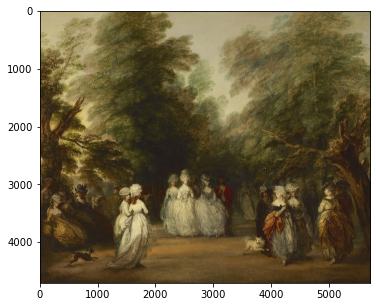

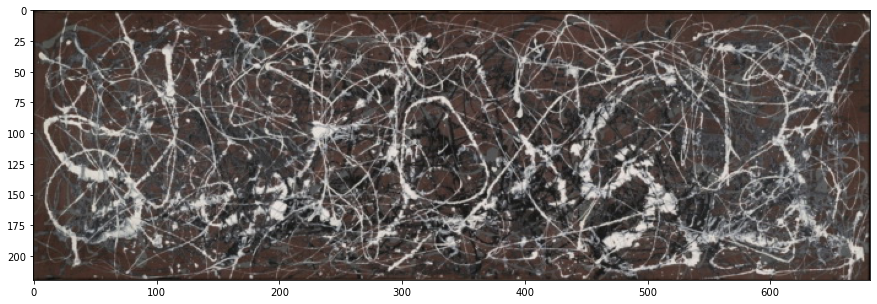

In [28]:
# looking at some images
archive = z.ZipFile('train.zip', 'r')
file = df_sub.loc[2]['new_filename']
imgdata = archive.open('train_1/'+file)
img = Image.open(imgdata)
plt.imshow(img)
plt.show()

file = df_sub.loc[19500]['new_filename']
imgdata = archive.open('train_1/'+file)
img = Image.open(imgdata)
plt.imshow(img)
plt.show()

In [29]:
df_sub['artist'].value_counts().head(10)

Boris Kustodiev          119
Pierre-Auguste Renoir    111
Ilya Repin               105
Claude Monet             103
Pyotr Konchalovsky       102
John Singer Sargent      101
Ivan Aivazovsky          100
Paul Cezanne             100
Odilon Redon              98
Camille Pissarro          97
Name: artist, dtype: int64

__largest number of paintings per artist in df_sub is 119 (compared to 500 in entire training data)__

In [30]:
by_artist_1 = pd.DataFrame(df_sub['artist'].value_counts().reset_index())
by_artist_1.columns = ['artist','count']
by_artist_1

,artist,count
0,Boris Kustodiev,119
1,Pierre-Auguste Renoir,111
2,Ilya Repin,105
3,Claude Monet,103
4,Pyotr Konchalovsky,102
...,...,...
1670,Scene Baptism of Christ,1
1671,Jester,1
1672,the central panel from St. Hippolytus Triptych,1
1673,Fire,1


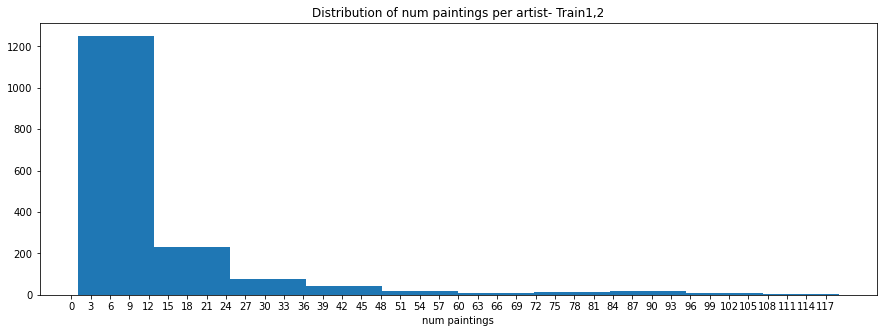

In [31]:
plt.hist(by_artist_1['count'])
plt.title('Distribution of num paintings per artist- Train1,2')
plt.xlabel('num paintings')
plt.xticks(range(0, 119,3))
plt.show()

In [32]:
# number of artists with > 80 paintings
len(by_artist_1[by_artist_1['count'] >= 80])

36

In [33]:
by_artist_1 = by_artist_1[by_artist_1['count'] >= 80]
# removing artists from the main df that have < 80 paintings
df_80 = df_sub[df_sub['artist'].isin(by_artist_1['artist'])]

In [34]:
print(df_80.shape)
print("num artists: ", len(df_80['artist'].unique()))
df_80.head()

(3347, 12)
num artists:  36


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
4,Henri de Toulouse-Lautrec,1895,genre painting,5833.0,3985.0,3389831.0,wikiart,Post-Impressionism,Abandonment (The pair),train_and_test,True,17354.jpg
16,Ernst Ludwig Kirchner,1910,genre painting,4728.0,3528.0,11325985.0,wikiart,Expressionism,Girl with Cat (Franzi),train_and_test,True,101495.jpg
52,Giovanni Battista Piranesi,NaN,cityscape,3893.0,3072.0,3777012.0,wikiart,Neoclassicism,Vedute di Roma,train_and_test,True,11889.jpg
61,Giovanni Battista Piranesi,NaN,cityscape,3899.0,2874.0,3882429.0,wikiart,Neoclassicism,Vedute di Roma,train_and_test,True,14108.jpg
68,Giovanni Battista Piranesi,NaN,cityscape,3899.0,2732.0,3779034.0,wikipedia,Neoclassicism,Vedute di Roma,train_and_test,True,1155.jpg


__df_80 has data from df_sub with artists having >= 80 paintings (max = 119)__

In [35]:
df_80.groupby('artist').size()

artist
Albrecht Durer                 95
Alfred Sisley                  84
Boris Kustodiev               119
Camille Corot                  94
Camille Pissarro               97
Childe Hassam                  84
Claude Monet                  103
Edgar Degas                    95
Ernst Ludwig Kirchner          83
Eugene Boudin                  95
Fernand Leger                  96
Giovanni Battista Piranesi     92
Gustave Dore                   88
Henri Martin                   81
Henri Matisse                  86
Henri de Toulouse-Lautrec      82
Ilya Repin                    105
Isaac Levitan                  84
Ivan Aivazovsky               100
Ivan Shishkin                  90
James Tissot                   81
John Singer Sargent           101
Marc Chagall                   92
Martiros Saryan                90
Nicholas Roerich               89
Odilon Redon                   98
Pablo Picasso                  92
Paul Cezanne                  100
Paul Gauguin                   97
Pierre-

In [36]:
# balancing the classes (making all artists have 80 paintings)
X = df_80.drop('artist', axis=1)
y = df_80['artist']
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

In [37]:
print(X_rus.shape)
print(36*81)
y_rus.value_counts()

(2916, 11)
2916


Albrecht Durer                81
Alfred Sisley                 81
James Tissot                  81
John Singer Sargent           81
Marc Chagall                  81
Martiros Saryan               81
Nicholas Roerich              81
Odilon Redon                  81
Pablo Picasso                 81
Paul Cezanne                  81
Paul Gauguin                  81
Pierre-Auguste Renoir         81
Pyotr Konchalovsky            81
Rembrandt                     81
Theophile Steinlen            81
Vincent van Gogh              81
Zdislav Beksinski             81
Ivan Shishkin                 81
Ivan Aivazovsky               81
Isaac Levitan                 81
Ernst Ludwig Kirchner         81
Boris Kustodiev               81
Camille Corot                 81
Camille Pissarro              81
Childe Hassam                 81
Claude Monet                  81
Edgar Degas                   81
Eugene Boudin                 81
Ilya Repin                    81
Fernand Leger                 81
Giovanni B

Resampled so dataset is now 36 artists each with 81 paintings

In [38]:
# saving X_rus and y_rus as pickle files
# X_rus.to_pickle("X_rus.pkl")
# y_rus.to_pickle("y_rus.pkl")

In [39]:
# X_rus = pd.read_pickle("X_rus.pkl")
# y_rus = pd.read_pickle("y_rus.pkl")

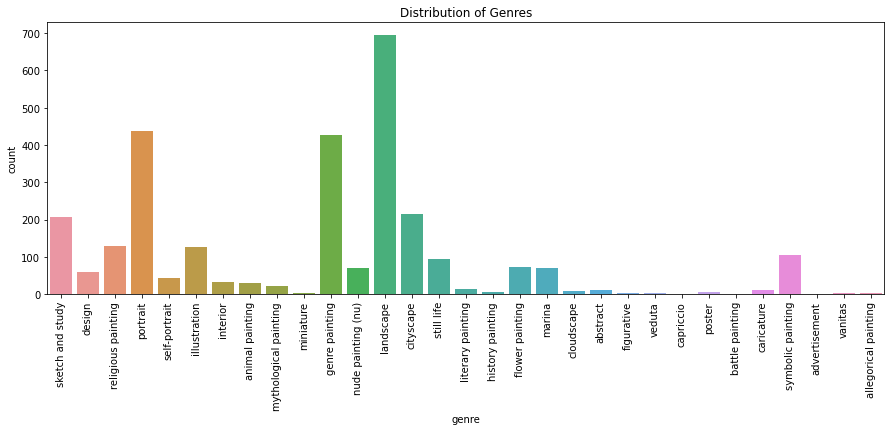

In [40]:
sns.countplot(x='genre', data=X_rus)
plt.xticks(rotation=90)
plt.title('Distribution of Genres')
plt.show()

### Resizing images to 256x256 according to paper. Also normalizing and creating dataloader

In [41]:
# directory = 'train_1'

# for filename in os.listdir(directory):
#     try:
#         if filename.endswith('.jpg'):
#             img_path = os.path.join(directory, filename)
#             with Image.open(img_path) as img:
#                 img_resized = img.resize((256, 256), resample=Image.BILINEAR)
#                 img_resized.convert('RGB').save(os.path.join(directory, filename))
#     except:
#         print(f"Could not process image {filename}")

In [42]:
# remove record of corrupted image file 101947.jpg
X_rus[X_rus['new_filename']=='101947.jpg'] #not included after resampling anyways

,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename


__Images resized to 256x256__

(256, 256)


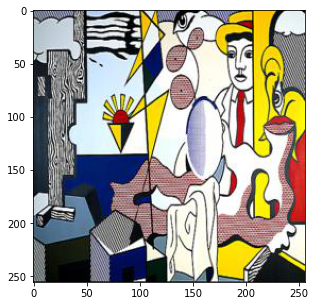

In [43]:
filename = df_sub.loc[19400]['new_filename'] 
img = Image.open(os.path.join('train_1', filename))
plt.imshow(img)
print(img.size)  # Should print (256, 256)

In [44]:
# transforming image - normalization improves performance
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # applying ImageNet normalization
    ])    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


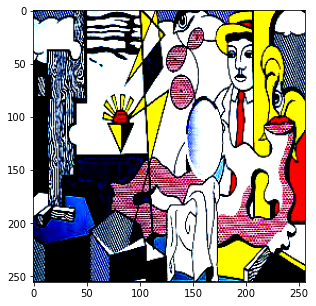

In [45]:
# look at transformed image
filename = df_sub.loc[19400]['new_filename'] 
img = Image.open(os.path.join('train_1', filename))
tr_img = transform(img)
plt.imshow(tr_img.numpy().transpose(1,2,0))
plt.show()

In [46]:
le = preprocessing.LabelEncoder() # one hot encoding instead? but 36 classes
artists = list(y_rus.unique())
le.fit(artists)
le.classes_

array(['Albrecht Durer', 'Alfred Sisley', 'Boris Kustodiev',
       'Camille Corot', 'Camille Pissarro', 'Childe Hassam',
       'Claude Monet', 'Edgar Degas', 'Ernst Ludwig Kirchner',
       'Eugene Boudin', 'Fernand Leger', 'Giovanni Battista Piranesi',
       'Gustave Dore', 'Henri Martin', 'Henri Matisse',
       'Henri de Toulouse-Lautrec', 'Ilya Repin', 'Isaac Levitan',
       'Ivan Aivazovsky', 'Ivan Shishkin', 'James Tissot',
       'John Singer Sargent', 'Marc Chagall', 'Martiros Saryan',
       'Nicholas Roerich', 'Odilon Redon', 'Pablo Picasso',
       'Paul Cezanne', 'Paul Gauguin', 'Pierre-Auguste Renoir',
       'Pyotr Konchalovsky', 'Rembrandt', 'Theophile Steinlen',
       'Vincent van Gogh', 'Zdislav Beksinski', 'Zinaida Serebriakova'],
      dtype='<U26')

In [47]:
l = le.transform(y_rus)
y_rus,l

(0             Albrecht Durer
 1             Albrecht Durer
 2             Albrecht Durer
 3             Albrecht Durer
 4             Albrecht Durer
                 ...         
 2911    Zinaida Serebriakova
 2912    Zinaida Serebriakova
 2913    Zinaida Serebriakova
 2914    Zinaida Serebriakova
 2915    Zinaida Serebriakova
 Name: artist, Length: 2916, dtype: object,
 array([ 0,  0,  0, ..., 35, 35, 35]))

In [76]:
# create dataloaders, batch size etc
class CustomImageDataset(Dataset):
    def __init__(self,img_dir, X,y, transformation): # pass X_rus, y_rus, img_dir='train_1' for training
        self.transformation = transform
        # is encoder needed?
        self.encoder = le
        self.img_dir = img_dir
        self.feats, self.labels = self.get_all(self.img_dir,X,y)
        
    def get_all(self,img_dir,X,y):
        images = []
        labels = []
        
        for index, row in X.iterrows():
            file = row['new_filename']
            img = Image.open(os.path.join(img_dir, file)) 
            data = self.transformation(img)
            images.append(data)
            
            
        labels = self.encoder.transform(y)
        
        
        images = torch.stack(images)
        labels = torch.LongTensor(labels)
        return images, labels
            
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,item):
        return self.feats[item], self.labels[item]
        

In [77]:
# need to do similar for test data^

In [78]:
#trainset = CustomImageDataset('train_1',X_rus,y_rus,transform)

In [79]:
#torch.save(trainset,"trainset.pt")

In [80]:
# load saved Dataset
trainset = torch.load("trainset.pt")

In [81]:
# split into train and val [80:20]
batch_size= 32
labels = trainset.labels.numpy()
train_indices, val_indices = train_test_split(np.arange(len(labels)),test_size=0.2,
                                              shuffle=True,random_state=42,stratify=labels)
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler,drop_last=True)
val_loader = DataLoader(trainset, batch_size=batch_size, sampler=val_sampler,drop_last=True)

### Baseline CNN
Based on: http://cs229.stanford.edu/proj2018/report/41.pdf

In [82]:
num_classes = 36

In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)

cpu


In [84]:
class CNNBase(nn.Module):
    def __init__(self):
        super(CNNBase,self).__init__()
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,16,3,padding=1)
        self.conv3 = nn.Conv2d(16,16,3,padding=1)
        self.conv4 = nn.Conv2d(16,32,3,padding=1)
        self.conv5 = nn.Conv2d(32,128,3,padding=1)
        self.conv6 = nn.Conv2d(128,256,3,padding=1)
        self.relu = nn.ReLU()
        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(16384,2048)
        self.fc2 = nn.Linear(2048,num_classes)
        self.pool = nn.MaxPool2d(2) 
        #self.softmax = nn.Softmax(dim=1) need to remove during training as cross entropy loss already has softmax
        
    def forward(self,x):
        #print("start: ", x.shape)
        x = self.relu(self.bn16(self.conv1(x)))
        #print("conv1: ", x.shape)
        x = self.pool(self.relu(self.bn16(self.conv2(x))))
        #print("conv2: ", x.shape)
        x = self.pool(self.relu(self.bn16(self.conv3(x))))
        #print("conv3: ", x.shape)
        x = self.pool(self.relu(self.bn32(self.conv4(x))))
        #print("conv4: ", x.shape)
        x = self.pool(self.relu(self.bn128(self.conv5(x))))
        #print("conv5: ", x.shape)
        x = self.pool(self.relu(self.bn256(self.conv6(x))))
        #print("conv6: ", x.shape)
        x = torch.flatten(x, start_dim=1)
        #print("flatten: ", x.shape)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        #print("fc1: ", x.shape)
        x = self.fc2(x)
        #print("fc2: ", x.shape)
        x = self.dropout(x)
        return x


In [85]:
cnn_base = CNNBase()
cnn_base.to(device)

CNNBase(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (bn16): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=16384, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, ou

In [86]:
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(cnn_base.parameters())

In [87]:
for i, data in enumerate(train_loader, 0):
    inputs,labels = data
    print(inputs.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 256, 256])
torch.Size([32])


In [88]:
epochs = 100
train_losses = []
val_losses = []
best_model_path = 'best_model.pt'
best_val_loss = float('inf')

for epoch in range(epochs):
    batch_loss = []
    cnn_base.train()
    
    for i, data in enumerate(train_loader, 0):
        inputs,labels = data
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()
        
        # forward step
        outputs = cnn_base(inputs)
        loss = loss_func(outputs,labels)
        
        # backward pass
        loss.backward()
        
        # update parameters
        opt.step()
        
        batch_loss.append(loss.data.item())
        
    train_loss = np.mean(batch_loss)
    train_losses.append(train_loss)
    
    cnn_base.eval()
    batch_loss = []
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs,labels = data
            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # forward step
            outputs = cnn_base(inputs)
            loss = loss_func(outputs,labels)

            batch_loss.append(loss.data.item())
        val_loss = np.mean(batch_loss)
        val_losses.append(val_loss)
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(cnn_base.state_dict(), best_model_path)
    #if epoch%10==0:
    print(f"[{epoch+1}/{epochs}] Training loss: {train_loss:.4f}\t Validation loss: {val_loss:.4f}.")

[1/100] Training loss: 6.8089	 Validation loss: 3.5744.
[2/100] Training loss: 3.5648	 Validation loss: 3.5940.
[3/100] Training loss: 3.5300	 Validation loss: 3.5474.
[4/100] Training loss: 3.5100	 Validation loss: 3.5368.
[5/100] Training loss: 3.4930	 Validation loss: 3.5334.
[6/100] Training loss: 3.4789	 Validation loss: 3.5761.
[7/100] Training loss: 3.4412	 Validation loss: 3.5341.
[8/100] Training loss: 3.3933	 Validation loss: 3.5785.
[9/100] Training loss: 3.3580	 Validation loss: 3.5457.
[10/100] Training loss: 3.3565	 Validation loss: 3.5086.
[11/100] Training loss: 3.3073	 Validation loss: 3.5356.
[12/100] Training loss: 3.3085	 Validation loss: 3.5811.
[13/100] Training loss: 3.3026	 Validation loss: 3.7017.
[14/100] Training loss: 3.2981	 Validation loss: 3.7308.
[15/100] Training loss: 3.2654	 Validation loss: 3.6231.
[16/100] Training loss: 3.2325	 Validation loss: 3.5101.
[17/100] Training loss: 3.1976	 Validation loss: 3.5149.
[18/100] Training loss: 3.1723	 Validati

In [89]:
torch.save(cnn_base.state_dict(), 'latest_model.pt')

In [94]:
# Python program to store list to file using pickle module
import pickle

# write list to binary file
def write_list(a_list, file_name):
    # store list in binary file so 'wb' mode
    with open(file_name, 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into a binary file')

# Read list to memory
def read_list(file_name):
    # for reading also binary mode is important
    with open(file_name, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

In [95]:
write_list(train_losses,'train_losses')

Done writing list into a binary file


In [100]:
write_list(val_losses,'val_losses')

Done writing list into a binary file


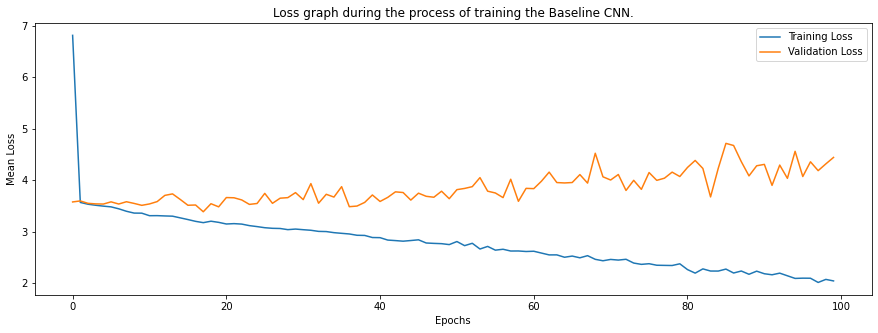

In [101]:
# plot the loss diagram
plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='best')
plt.ylabel('Mean Loss')
plt.xlabel('Epochs')
plt.title(f"Loss graph during the process of training the Baseline CNN.")
plt.show()

Model has overfit. Likely because our data size is much smaller than what the paper used

In [103]:
# evaluate on test set

In [104]:
# create test dataloader etc